# Module 3 - Deployment & Hardware Considerations

> **Introduction**

Let's talk about what the problem is
now that we have with these large
language models they're becoming extra
large.
What this comes down to is really memory.
We found that these LLMs that have hundreds of billions of
parameters don't tend to fit on consumer
or enterprise GPUs.
We've seen from our very **LLMs that as they grow in size they
tend to perform better, both with the
accuracy of their output, and they're able to
be better aligned with what we need them
to do, and they have much broader range
of abilities to solve different types of
tasks**.

However, **this comes at a cost, particularly of speed**, which we even saw
in Module 1 when GPT-2 extra large took
much longer to produce the output. The
memory footprint, if you're a developer
of large language models then the out of
memory error is something you're going to
be all too familiar with. But also
updateability, if we have new data that
comes in and we need to keep training
our models the larger they are the
harder this is to do, and so we end up
with a choice. 
- Do we have to pick a small model that is at least fast, but doesn't have the quality
- Try to work with a very large model and spend as much as we can on our compute resources to make use of that high quality
- What if we could do both, what we're going to do in this Module is we're going to **take another look at some of the components inside the Transformer itself to see if we can make some improvements and help alleviate some of these issues**
- We'll also look at how **quantization can allow us to utilize LLMs that have been trained already and convert them to smaller versions of them without sacrificing too much in performance**

> **Improving Learning Efficiency**

Let's talk about the context length, that's
effectively the amount of information
that we put into one of the prompts that
the LLM will use to interpret what is being asked or the
type of conversation that's going on.
Like us, we do better with contexts that
are larger, so do large language models.

However, increasing large language model
context length isn't as simple as you
might think. If you think about the
attention mechanism, and how that
operates.
In theory, you can have those longer
context length as you want the
operations that go through the query, key,
and value vectors
span across the entire sequence length.
There's no limit of what that sequence
length can be, and that doesn't affect
the parameters. The parameters are based
on the dimensionality that you have for
each of your word embedding vectors.

When **we increase the size of the context
length and we apply an attention
mechanism over that context, the
computing of input values increases
somewhat linearly, performing the
position-wise feed forward network
calculations also increases linearly**.

However, **calculating the attention scores
themselves increases quadratically, and
that's because we have a, N by N matrix**
to deal with, and even worse than this, is the fact
that if we train on a context length of
say 1000
and then we perform inferences on context
lengths they're twice as long as
this or three times or ten times the
performance of the models are shown to
get far worse.

**One of the reasons that is likely for
this, is the positional encoding that we
use when we give the information of how
one token is related to another in
position to the attention mechanism**.
We saw that we use the positional encoding using the sines and
cosines to give a relative sense of how
these tokens are positioned relative to
another. However **it appears that this
doesn't allow for the neural network or
the attention mechanism to understand
very well how these are different when
we train on one length and test on a
much longer length**. You can see the
**perplexity scores, which is how well it
knows which token to select next**, *get
worse and worse as you change the number
of contexts*.

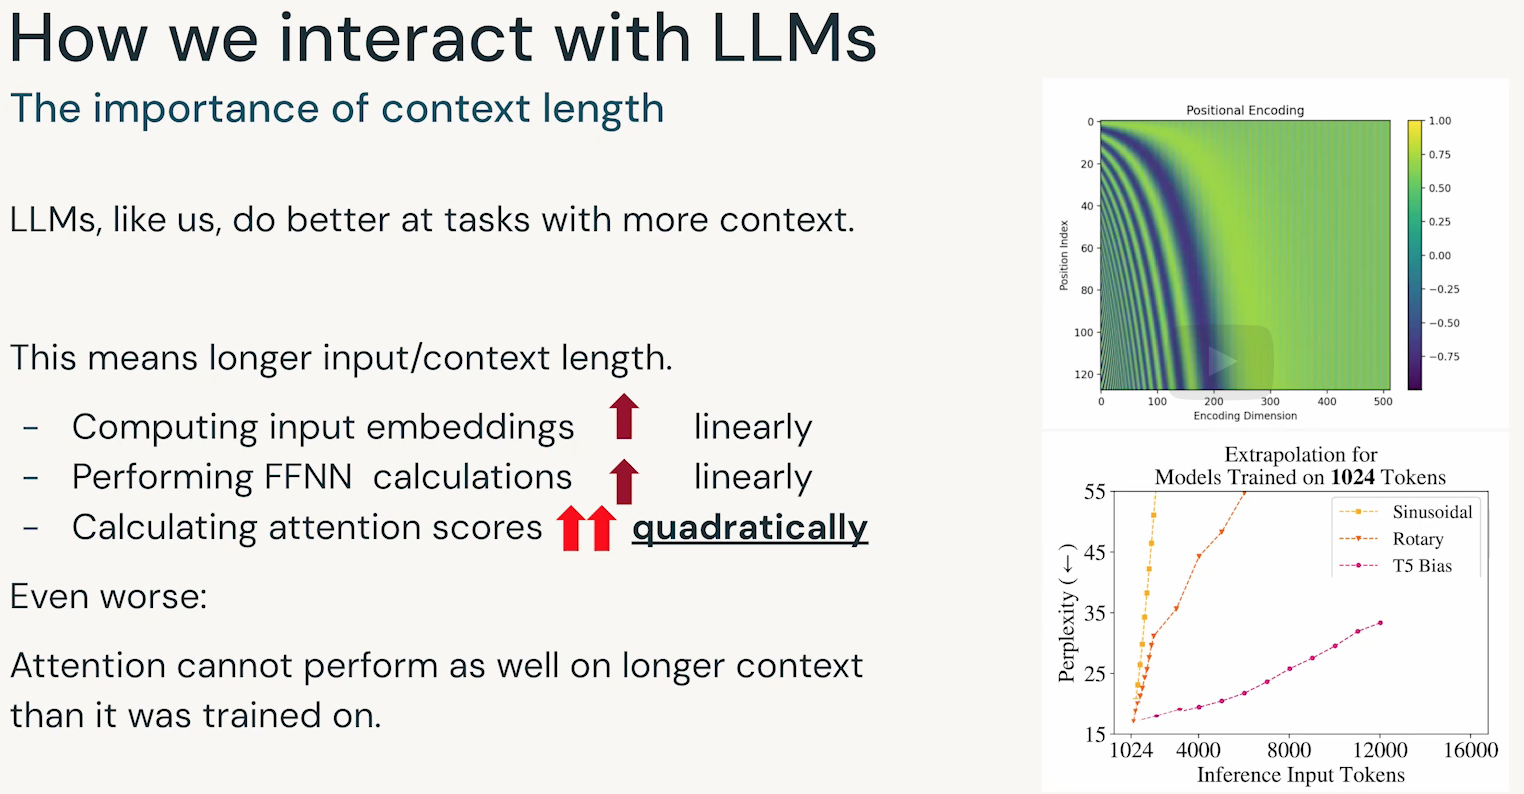

> **Faster Calculations**

When the context lengths gets bigger and bigger, and the performance of the LLm decreases, we can try to fix this by addressing the attention mechanism itself. In the attention mechanism, we provide a
query vector and look at all of the keys.
Now, one innovation that was introduced
which is called *ALiBi*, took an approach
by *weighting the these particular pairs
of vectors, the query times the key and
just applied a linear basis so that
tokens that were one step away from the
current query token we're given a scale
of negative one times by some factor*. What this
means though, is that **you can train on a
relatively short context length and
increase it in inference to almost any
size that you want**.

This has enabled the context lengths to
be at a maximum of something like 4000
all the way up to 32,000
64,000 and in some cases
even larger than 100,000. This
means that we can add a lot more
information into our context lengths,
including documents, code bases, and chat
histories, and we get even more
performance from our large language
models. 

This is fantastic however but we have a problem, you
might also then realize, based on what we
were talking, that the compute resources required to have
much longer inferences now become an issue.
This is no longer an issue of storing
the model on memory, just loading the
parameters in, **but actually creating
these attention weights themselves. They
are now an issue that we'll have to deal with**.

Of the many solutions trying to fix this problem, in particular, one that is
catching most of the attention of the wider community is something called
**FlashAttention**.

*FlashAttention leverages something that we've seen
in linear algebra* before, where we don't
actually need to materialize these large
matrices at all. We can actually do this
in a *matrix free operation, because we know which index one vector
will need to interact with the index of
another vector, we can actually just take
these individual variables one by one*.

The reason that this is an *important
approach is because we need to look at
the hardware that's used when we
calculate attention*.
If we think about what goes on inside
the GPU when we're calculating our
attention scores we actually interact
with something called the SRAM. This is
akin to the cache that's on a CPU and
it's basically very fast memory that's
very small but very close to the compute
units.
In the **case of LLMs,
this SRAM gets overloaded very quickly
when we try to load in the full matrix
of the attention**.
*If we never actually materialize the
attention matrix, then we can keep
sending the individual variables to the
SRAM and line it up so that we never
have to go back to the slower memory and
incur the performance costs that you
would if you had to put the entire
matrix onto this SRAM that just isn't
large enough*.

Using something like FlashAttention, and
it's later variants, we see an order of
magnitude speed up in calculating these
longer attentions that are coming from
the fact that we are now able to use
longer contexts.

> **Multi-Head Attention**

Looking even more at the attention
mechanism, we can think of other ways
that we can try and improve this process.

Multi-head attention takes the entire
attention matrices of the key
and value matrices and splits them into
multiple heads. This means that *we send a
query to a number of different matrices
but their sum total is the same size as
if we just have a single matrix*.

The **reason that we might want to split
this into multi-headed attention is it
allows these different versions of keys,
queries, and values to focus on different
parts of the speech**.
By splitting these up into multiple
heads, you might have one head looking at
nouns, one looking at prepositions, and
one looking at other parts of speech.
However, while this produces more
accurate results as we get a more
detailed and enriched version of what we
end up with at the end of our attention
scores, **this is slower as we have to do
these calculations in multiple steps (more multi-head attention = slower calculation process)**.

Some improvements to this have included
multi-query attention, where actually we
create different copies of our query
vector and feed them into just one key
and value vector.
The **issue with this however, while it is
much faster than doing multi-headed
attention, it tends not to capture all of
the differences** in the nuances that we
need when we're looking at something
like a multi-headed attention case.

The happy medium to this is **grouped
query attention**, which is what large
language models like LLama 2 leverage. In
this situation, while **we have a number of
different
heads for our attention mechanism, we
send them a few different query vectors**.
Keep in mind these query vectors come
from the same token, but they use
slightly different projection operations
so that we have different versions of
those query vectors for the key vectors
to look at.
This **enables us to leverage the
multi-headed, multi-focus, version that we
get in multi-headed attention with some
of the speed-ups in the multi-query
attention**.
Grouped query attention is one of the
latest innovations that we've seen so
far in improving the attention operation (April 10th, 2024).

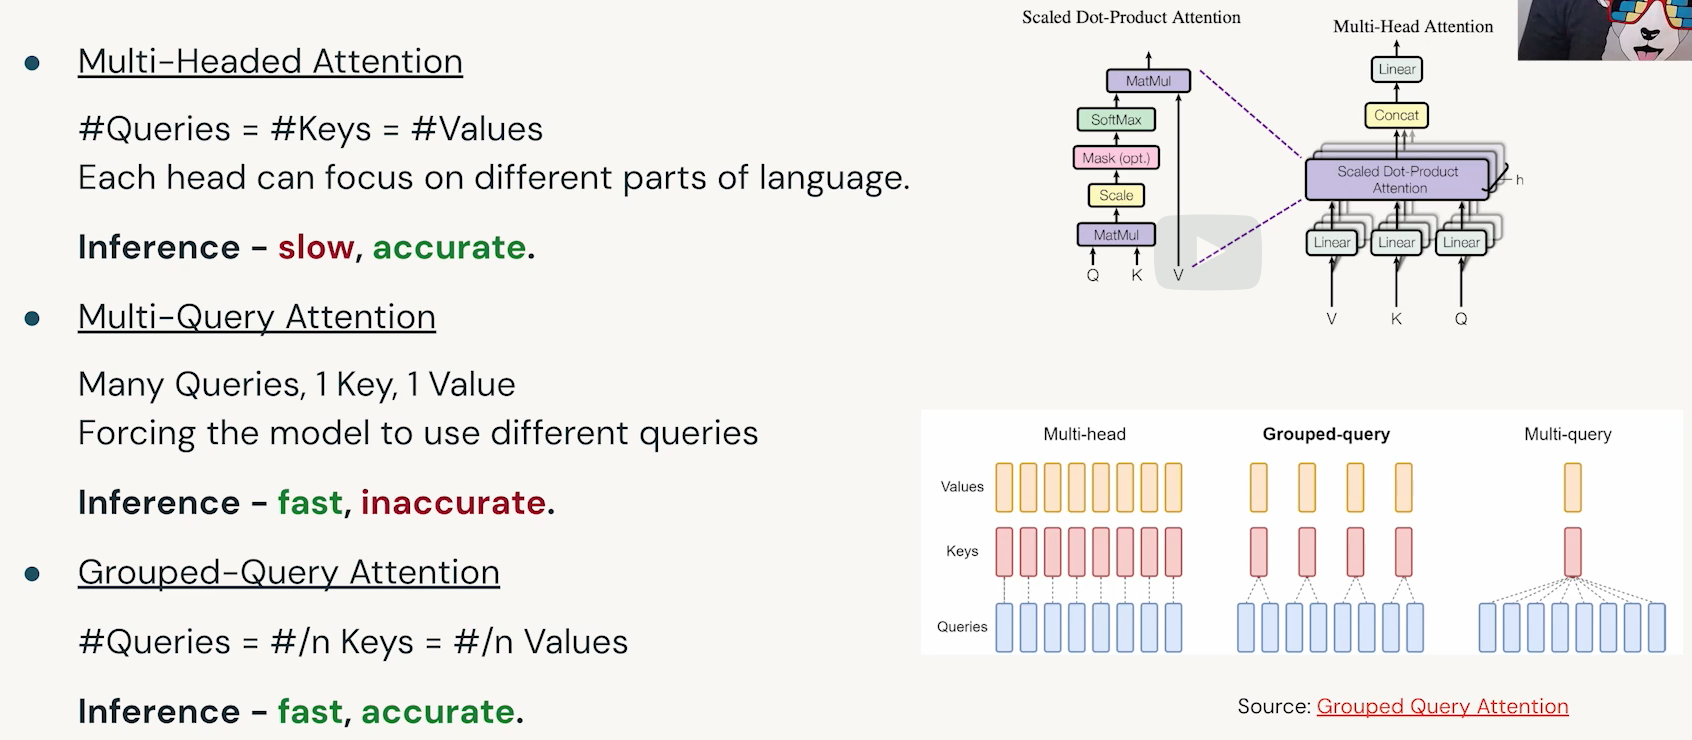

> **Improving Model Footprint**

**What is Quantization?**

- Quantization is a technique to reduce the storage space of LLMs.
- It converts numbers from high-precision floating-point format (e.g., 32-bit) to lower-precision integers (e.g., 8-bit).
- This reduces storage requirements but can introduce some loss of accuracy.


**How Does Quantization Work?**

- Standard floating-point numbers allocate bits for the exponent (magnitude) and mantissa (digits).
- Quantization scales the floating-point numbers to a specific range and rounds them to integers.
- This is similar to grouping numbers into buckets instead of storing them as continuous values.


**Benefits of Quantization**

- Smaller model size allows running LLMs on less powerful hardware (consumer devices). Example: Quantized LoRA (QLoRA)
- This technique uses quantization to run large LLMs on small devices.
- It quantizes the core component of LLMs (Transformer) to a low-precision format (like 4-bit).
- It also reduces the size of adapter modules and stores optimizer state efficiently.


**Limitations of Quantization**

- There's a trade-off between efficiency and accuracy.
- Excessive quantization (very low-bit representations) can significantly impact LLM performance.
T- he text suggests a limit around 4-bit for 100 billion parameter models.

> **Multi-LLM Inference**

**Using Multiple Large Language Models (LLMs) for Efficiency**

Mixture of Experts:

- Concept: This method utilizes multiple smaller, specialized LLMs instead of a single, massive model.
- Inspiration: Similar to ensemble methods in machine learning, where multiple models contribute to a final prediction.



**How it Works**
- An input is routed by a trained "router" to the most suitable LLM expert for that specific task.
- These experts can be specialized Transformers with different "feed forward neural networks" (FFNs).
- FFNs process information after the attention mechanism in a Transformer block.
- The router learns to send the input to the most appropriate expert(s) during training.
- The final output can be an aggregation of multiple expert outputs.



**Benefits**
- Allows training on massive datasets by distributing the workload among multiple smaller models.
- Enables building even larger models (trillions of parameters) by combining multiple 100-billion parameter models.



**Limitations**
- Still requires significant computational resources.
- Existing optimizations for single LLMs remain valuable for mixture of experts approaches.
- Research on mixture of experts for LLMs is ongoing, with promising results demonstrated by the "switch Transformer" technique.

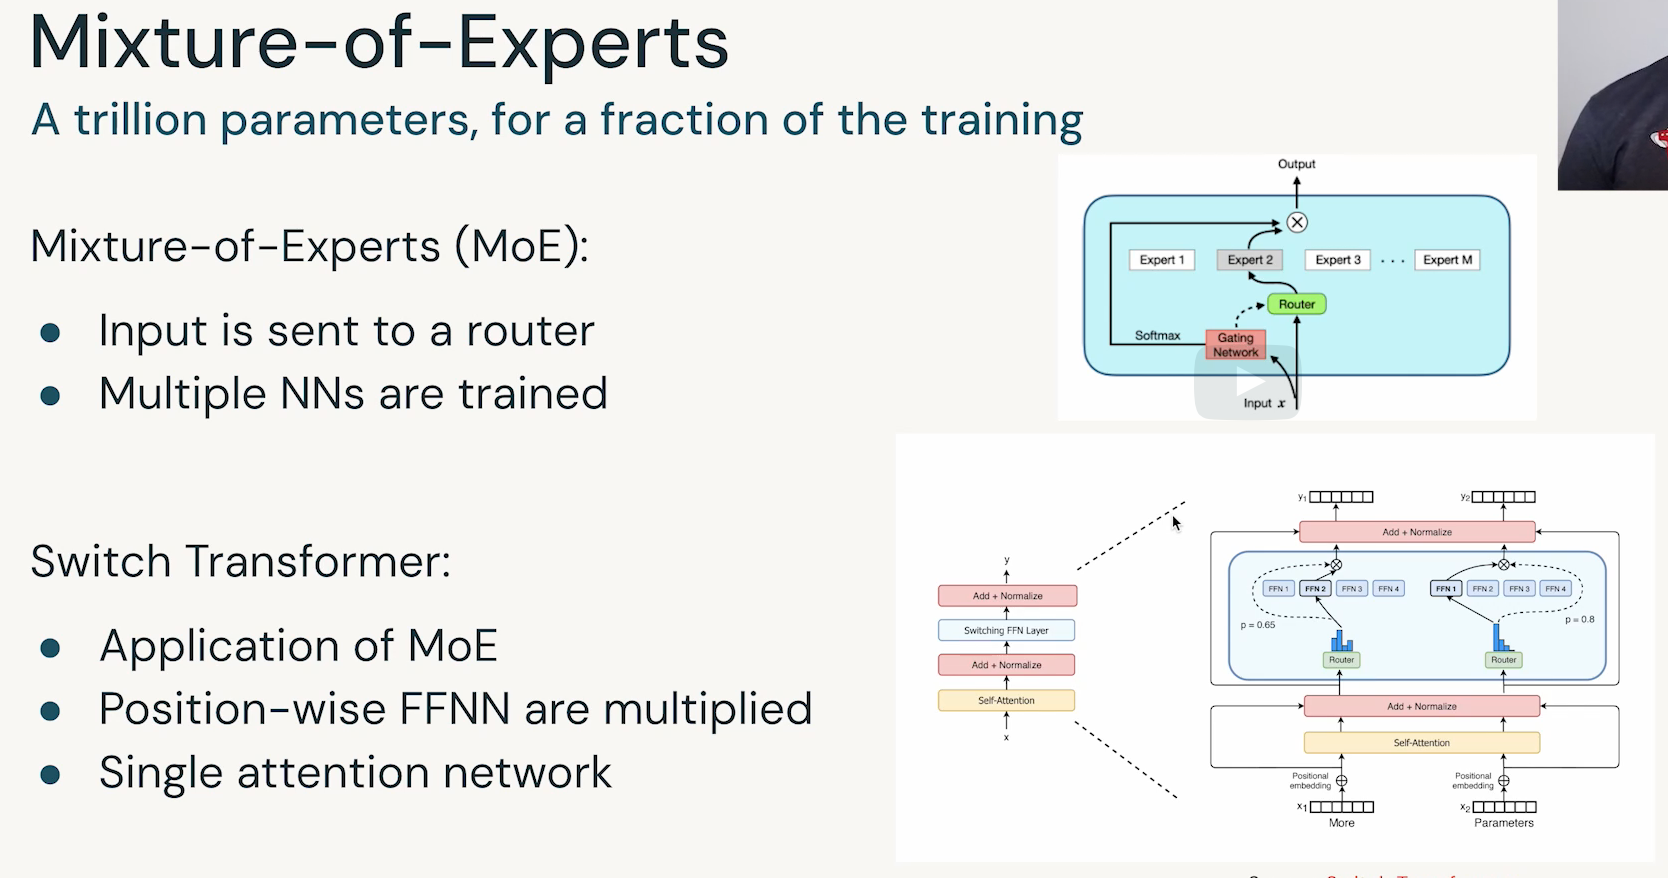

**Cost-Effective Inference with LLMs**

This section discusses techniques for using LLMs efficiently when cost is a major concern, particularly for inference tasks performed through APIs. 

- LLM Cascade
    - Reduces inference cost by cascading multiple LLM models with varying complexity.
    - The cascading approach maintains high accuracy while significantly reducing inference costs.
    - Works by:
        1. Sending a prompt to the simplest (least expensive) LLM first.
        2. Analyzing the model's output perplexity (a measure of uncertainty).
        3. If perplexity is high (indicating low confidence), skipping this output and moving to a more complex (expensive) LLM.
        
 
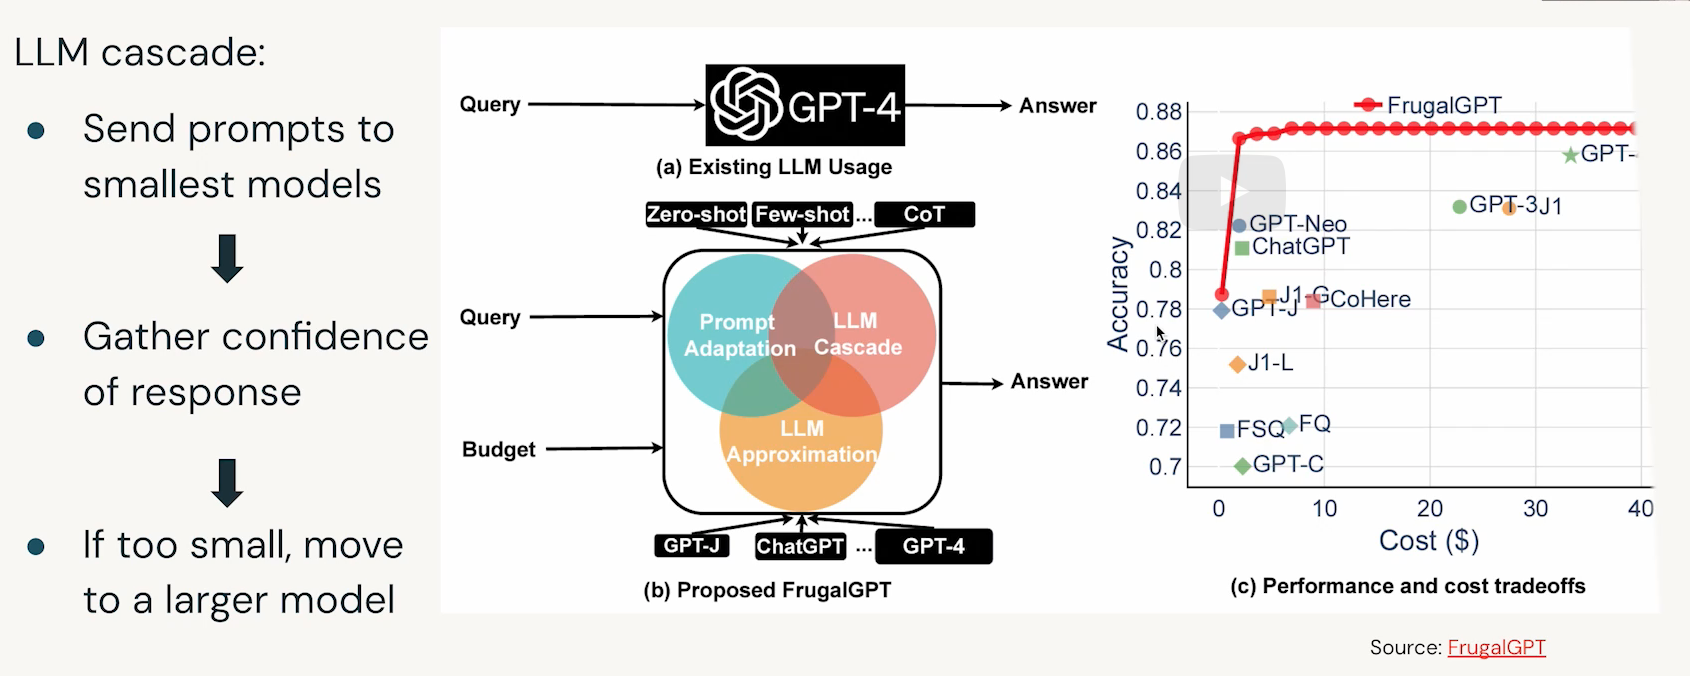

> **Best Practices for Training and Deloying LLMs**

- **Training**
    - Techniques for Large Context Lengths
        - **Incorporate ALiBi**: Enables training on very large contexts exceeding what the model is explicitly trained on.
        - **Leverage FlashAttention**: Reduces memory usage on GPUs during attention calculations, allowing for even larger contexts.
        - **Utilize Grouped Query Attention**: Saves compute resources and reduces parameters required for the attention mechanism.
    - Scaling Large Language Models: Consider the mixture of experts approach for extremely large models.    


- **Deployment & Inference**
    - **Fine-tuning and Inference**: Utilize tools like LoRA or quantized LoRA for efficient fine-tuning and inference.
    - **Cost-effective Inference**: Leverage techniques like Frugal GPT and LLM Cascades to minimize inference costs based on budget constraints.


**Note:** GPU memory requirements roughly double with the number of parameters in your model.
Example: A 7 billion parameter model requires around 14 Gigabytes of GPU memory for inference, and even more for training.

> **Summary**

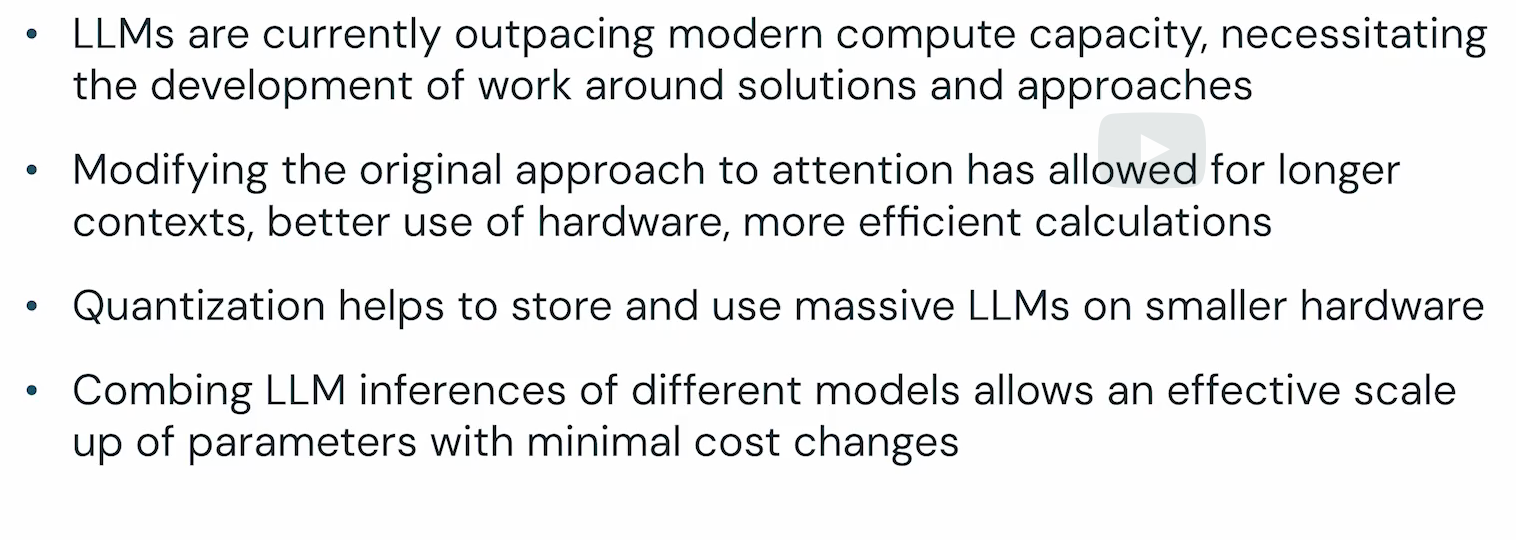